## Numpy tests

In [1]:
import numpy as np
print('OK')

OK


In [2]:
import datetime
datetime.datetime.now()

datetime.datetime(2022, 5, 12, 21, 38, 16, 310259)

## Charge parameters

In [1]:
import grid2op
import numpy as np
from lightsim2grid import LightSimBackend
from grid2op.Chronics import MultifolderWithCache
from l2rpn_baselines.utils import GymEnvWithRecoWithDN
from grid2op.Parameters import Parameters
from grid2op.utils import ScoreL2RPN2020
import torch
import datetime
import sys
import re
import os
import matplotlib.pyplot as plt

from utils import *

from examples.ppo_stable_baselines.B_train_agent import CustomReward

2022-05-11 19:56:31.809221: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-11 19:56:31.809245: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/boguslawskieva/miniconda3/envs/baselines_dev/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ENV_NAME = "l2rpn_wcci_2022_dev"

# Split sets and statistics parameters
is_windows = sys.platform.startswith("win32")
is_windows_or_darwin = sys.platform.startswith("win32") or sys.platform.startswith("darwin")
nb_process_stats = 4 if not is_windows_or_darwin else 1
deep_copy = is_windows  # force the deep copy on windows (due to permission issue in symlink in windows)
verbose = 1
SCOREUSED = ScoreL2RPN2020  # ScoreICAPS2021
name_stats = "_reco_powerline"

# Train parameters
env_name_train = '_'.join([ENV_NAME, "train"])
save_path = "./saved_model"
name = '_'.join(["GymEnvWithRecoWithDN", datetime.datetime.now().strftime('%Y-%m-%d_%H-%M')])
gymenv_class = GymEnvWithRecoWithDN

In [16]:
def filter_chronics(x):
  list_chronics = ['2050-01-10_0', '2050-08-01_7'] # Names of chronics to keep
  p = re.compile(".*(" + '|'.join([c + '$' for c in list_chronics]) + ")")
  return re.match(p, x) is not None

In [4]:
p=Parameters()
p.LIMIT_INFEASIBLE_CURTAILMENT_STORAGE_ACTION = True

env_train = grid2op.make(ENV_NAME,
                   reward_class=CustomReward2,
                   backend=LightSimBackend(),
                   chronics_class=MultifolderWithCache,
                   param=p,
                   other_rewards={"CustomReward": CustomReward}
                   )
# env_train.chronics_handler.real_data.set_filter(filter_chronics)
# env_train.chronics_handler.real_data.reset()

## Test Runner

In [ ]:
from grid2op.Runner import Runner
from examples.ppo_stable_baselines.C_evaluate_trained_model import load_agent

from grid2op.PlotGrid import PlotMatplot
plot_helper = PlotMatplot(observation_space=env_train.observation_space)

In [ ]:
# agent_name = "GymEnvWithRecoWithDN_2022-04-23_01-20_learning_rate_1"
agent_name = "GymEnvWithRecoWithDN_2022-05-06_12-38_gymenv_kwargs_0"
path_agent = os.path.join(save_path, agent_name)
path_results_agent = os.path.join("./model_results", agent_name)

In [9]:
my_agent = load_agent(env_train, 
    load_path=save_path, 
    name=agent_name, 
    gymenv_class=gymenv_class, 
    gymenv_kwargs={"safe_max_rho": 0.2})

In [10]:
runner_params = env_train.get_params_for_runner()
runner_params["verbose"] = verbose
runner = Runner(**runner_params, agentClass=None, agentInstance=my_agent)

In [11]:
os.makedirs(path_results_agent, exist_ok=True)

res = runner.run(path_save=path_results_agent, 
    nb_episode=2, 
    nb_process=1, 
    max_iter=-1, 
    pbar=True,
    env_seeds=get_env_seed(ENV_NAME)[:2], 
    # env_seeds=[42 for _ in range(2)],
    agent_seeds=[0 for _ in range(2)])

episode:  12%|█▏        | 235/2017 [00:01<00:09, 195.84it/s]


2050-01-10_0: env.nb_time_step = 235, reward : 0.341
2050-01-10_0: env.nb_time_step = 235, reward : 0.341


episode: 100%|██████████| 2017/2017 [00:08<00:00, 246.34it/s]


2050-08-01_7: env.nb_time_step = 2017, reward : 1.000
2050-08-01_7: env.nb_time_step = 2017, reward : 1.000


episode: 100%|██████████| 2/2 [00:11<00:00,  5.69s/it]


In [11]:
for i, agent_name in enumerate(["GymEnvWithRecoWithDN_2022-05-10_20-55_learning_rate_0", 
                      "GymEnvWithRecoWithDN_2022-05-11_10-08_learning_rate_0",
                      "GymEnvWithRecoWithDN_2022-05-11_10-08_learning_rate_1",
                      "GymEnvWithRecoWithDN_2022-05-11_10-08_learning_rate_2",
                      "GymEnvWithRecoWithDN_2022-05-11_11-01_learning_rate_0"]):
  results = eval_agent(ENV_NAME, #env_name_val,
            2,
            agent_name,
            save_path,
            SCOREUSED,
            gymenv_class,
            verbose,
            gymenv_kwargs={"safe_max_rho":0.9},
            param=p,
            filter_fun=filter_chronics)
  print(results)


Starts the evaluation of the agent
Start the evaluation of the scores
	:-( I survived 139 steps vs 280 for do nothing (-141)
	:-) I survived 2017 steps vs 127 for do nothing (1890)
The agent "GymEnvWithRecoWithDN_2022-05-10_20-55_learning_rate_0" beats "do nothing" baseline in 1 out of 2 episodes
	:-( I survived 139 steps vs 280 for reco powerline (-141)
	:-) I survived 2017 steps vs 131 for reco powerline (1886)
The agent "GymEnvWithRecoWithDN_2022-05-10_20-55_learning_rate_0" beats "reco powerline" baseline in 1 out of 2 episodes
([139, 2017], array([280, 127]), array([280, 131]))
Starts the evaluation of the agent
Start the evaluation of the scores
	:-( I survived 222 steps vs 280 for do nothing (-58)
	:-( I survived 113 steps vs 127 for do nothing (-14)
The agent "GymEnvWithRecoWithDN_2022-05-11_10-08_learning_rate_0" beats "do nothing" baseline in 0 out of 2 episodes
	:-( I survived 222 steps vs 280 for reco powerline (-58)
	:-( I survived 113 steps vs 131 for reco powerline (-18)

In [8]:
for i, agent_name in enumerate(["GymEnvWithRecoWithDN_2022-05-11_11-02_learning_rate_0",  
                      "GymEnvWithRecoWithDN_2022-05-11_11-11_learning_rate_0"]):
  results = eval_agent(ENV_NAME, #env_name_val,
            2,
            agent_name,
            save_path,
            SCOREUSED,
            gymenv_class,
            verbose,
            gymenv_kwargs={"safe_max_rho":0.9},
            param=p,
            filter_fun=filter_chronics)
  print(results)

Starts the evaluation of the agent
Start the evaluation of the scores
	:-( I survived 127 steps vs 280 for do nothing (-153)
	:-) I survived 2017 steps vs 127 for do nothing (1890)
The agent "GymEnvWithRecoWithDN_2022-05-11_11-02_learning_rate_0" beats "do nothing" baseline in 1 out of 2 episodes
	:-( I survived 127 steps vs 280 for reco powerline (-153)
	:-) I survived 2017 steps vs 131 for reco powerline (1886)
The agent "GymEnvWithRecoWithDN_2022-05-11_11-02_learning_rate_0" beats "reco powerline" baseline in 1 out of 2 episodes
([127, 2017], array([280, 127]), array([280, 131]))
Starts the evaluation of the agent
Start the evaluation of the scores
	:-( I survived 170 steps vs 280 for do nothing (-110)
	:-) I survived 2017 steps vs 127 for do nothing (1890)
The agent "GymEnvWithRecoWithDN_2022-05-11_11-11_learning_rate_0" beats "do nothing" baseline in 1 out of 2 episodes
	:-( I survived 170 steps vs 280 for reco powerline (-110)
	:-) I survived 2017 steps vs 131 for reco powerline 

## Study episodes

In [19]:
from grid2op.Episode import EpisodeData
episode_studied = EpisodeData.list_episode(path_results_agent)
episode_studied

[('/home/boguslawskieva/L2RPN-WCCI-Baselines/RL/model_results/GymEnvWithRecoWithDN_2022-05-06_12-38_gymenv_kwargs_0',
  '2050-01-10_0'),
 ('/home/boguslawskieva/L2RPN-WCCI-Baselines/RL/model_results/GymEnvWithRecoWithDN_2022-05-06_12-38_gymenv_kwargs_0',
  '2050-08-01_7')]

In [20]:
this_episode = EpisodeData.from_disk(*episode_studied[1])

In [21]:
i = 0
for t, act in enumerate(this_episode.actions):
    if act != env_train.action_space(): # Print only when an action is done
        i += 1
        obs = this_episode.observations[t]
        print(i)
        print(t)
        print(act)
        # _ = plot_helper.plot_obs(obs)

1
0
This action will:
	 - NOT change anything to the injections
	 - NOT perform any redispatching action
	 - Modify the storage units in the following way:
	 	 - Ask unit "storage_22_0" to produce 0.85 MW (setpoint: -0.85 MW)
	 	 - Ask unit "storage_41_1" to absorb 8.67 MW (setpoint: 8.67 MW)
	 	 - Ask unit "storage_44_2" to produce 0.19 MW (setpoint: -0.19 MW)
	 	 - Ask unit "storage_58_3" to absorb 3.83 MW (setpoint: 3.83 MW)
	 	 - Ask unit "storage_76_4" to produce 4.39 MW (setpoint: -4.39 MW)
	 	 - Ask unit "storage_95_5" to absorb 6.22 MW (setpoint: 6.22 MW)
	 	 - Ask unit "storage_112_6" to absorb 0.47 MW (setpoint: 0.47 MW)
	 - Perform the following curtailment:
	 	 - Limit unit "gen_3_0" to 100.0% of its Pmax (setpoint: 1.000)
	 	 - Limit unit "gen_3_1" to 100.0% of its Pmax (setpoint: 1.000)
	 	 - Limit unit "gen_9_3" to 0.0% of its Pmax (setpoint: 0.000)
	 	 - Limit unit "gen_10_4" to 100.0% of its Pmax (setpoint: 1.000)
	 	 - Limit unit "gen_10_5" to 0.0% of its Pmax (setpoi

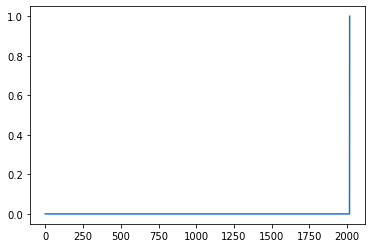

In [16]:
plt.plot(this_episode.rewards)

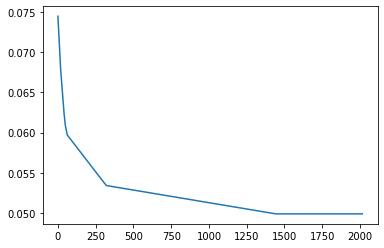

In [17]:
plt.plot([el['CustomReward2'] for el in this_episode.other_rewards][:-1])

In [129]:
this_episode.actions[0].curtail, this_episode.actions[0].set_storage

(array([ 1.        ,  1.        , -1.        ,  0.        ,  1.        ,
         0.55113685, -1.        ,  0.        , -1.        ,  1.        ,
        -1.        ,  1.        ,  1.        , -1.        ,  1.        ,
         1.        ,  1.        ,  0.        ,  0.        , -1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        -1.        ,  1.        ,  0.        ,  1.        ,  0.        ,
         1.        , -1.        , -1.        ,  0.        ,  1.        ,
        -1.        ,  1.        , -1.        , -1.        ,  1.        ,
         0.        , -1.        , -1.        ,  1.        ,  0.        ,
        -1.        ,  1.        ,  0.        ,  1.        ,  0.        ,
         0.        , -1.        ,  1.        , -1.        ,  0.9917599 ,
        -1.        ,  1.        ,  1.        , -1.        ,  1.        ,
        -1.        ,  0.        ], dtype=float32),
 array([-8.645507  ,  1.4393748 ,  6.17998   ,  4.3085036 ,  7.1264153 ,


**Regarder les observations et non les actions**

## Training curves

In [23]:
from l2rpn_baselines.PPO_SB3 import evaluate

In [ ]:
trained_agent, details = evaluate(env_train,
                                nb_episode=2,
                                load_path=save_path,
                                name=agent_name,
                                gymenv_class=gymenv_class,
                                iter_num=700000,
                                # iter_num=630000,
                                gymenv_kwargs={"safe_max_rho":0.9})
details

In [25]:
nb_iterations = 700_000
nb_iterations_list = np.arange(stop=nb_iterations+1, step=nb_iterations//10)[1:]
# agents_names_list = ["GymEnvWithRecoWithDN_2022-04-23_01-20_learning_rate_0", 
#                       "GymEnvWithRecoWithDN_2022-04-23_01-20_learning_rate_1", 
#                       "GymEnvWithRecoWithDN_2022-04-23_01-20_learning_rate_2"]

agents_names_list = ["GymEnvWithRecoWithDN_2022-05-06_12-38_gymenv_kwargs_0",
                    "GymEnvWithRecoWithDN_2022-05-11_11-02_learning_rate_0"]
                        



global_res = np.zeros((2, 3, 2, nb_iterations_list.shape[0]))

for i, agent_name in enumerate(agents_names_list):
    for j, nb_iter in enumerate(nb_iterations_list):
        _, details = evaluate(env_train, #env_train,
                                nb_episode=2,
                                load_path=save_path,
                                name=agent_name,
                                gymenv_class=gymenv_class,
                                iter_num=nb_iter,
                                gymenv_kwargs={"safe_max_rho":0.2})

        # print(details)
        for l, el in enumerate(details):
            # print(global_res[l, i, j])
            # print(el[3])
            global_res[l, i, 0, j] = el[2] # Reward
            global_res[l, i, 1, j] = el[3]  # Timesteps survived

        print(agent_name, nb_iter)
        # print(global_res)
    
    

2050-01-10_0: env.nb_time_step = 697, reward : 0.588
2050-01-10_0: env.nb_time_step = 697, reward : 0.588
2050-08-01_7: env.nb_time_step = 2017, reward : 1.000
2050-08-01_7: env.nb_time_step = 2017, reward : 1.000
GymEnvWithRecoWithDN_2022-05-06_12-34_gymenv_kwargs_0 40000
2050-01-10_0: env.nb_time_step = 283, reward : 0.375
2050-01-10_0: env.nb_time_step = 283, reward : 0.375
2050-08-01_7: env.nb_time_step = 2017, reward : 1.000
2050-08-01_7: env.nb_time_step = 2017, reward : 1.000
GymEnvWithRecoWithDN_2022-05-06_12-34_gymenv_kwargs_0 80000
2050-01-10_0: env.nb_time_step = 280, reward : 0.373
2050-01-10_0: env.nb_time_step = 280, reward : 0.373
2050-08-01_7: env.nb_time_step = 2017, reward : 1.000
2050-08-01_7: env.nb_time_step = 2017, reward : 1.000
GymEnvWithRecoWithDN_2022-05-06_12-34_gymenv_kwargs_0 120000
2050-01-10_0: env.nb_time_step = 280, reward : 0.373
2050-01-10_0: env.nb_time_step = 280, reward : 0.373
2050-08-01_7: env.nb_time_step = 2017, reward : 1.000
2050-08-01_7: env

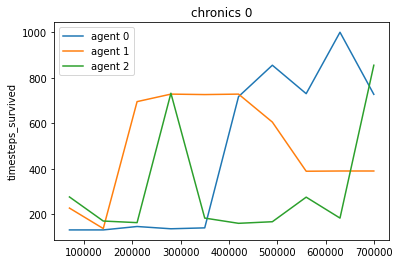

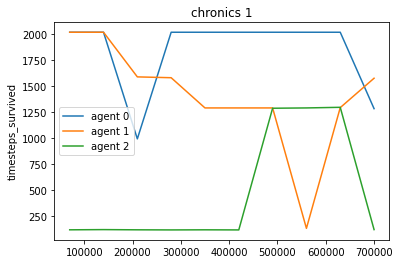

In [96]:
for chronics_num in range(2):
    for k, y_name in enumerate(["timesteps_survived"]):
        plt.title("chronics " + str(chronics_num))
        plt.ylabel(y_name)
        for agent_num in range(len(agents_names_list)):
            plt.plot(nb_iterations_list, global_res[chronics_num, agent_num, 1], label="agent "+str(agent_num))
        plt.legend()
        plt.show()


## Learning rate function

In [121]:
def lr_fun(x_left):
    x = 1 - x_left
    lr = 0
    if x <= 0.25:
        lr = 1e-3 + (1e-5 - 1e-3) * x / 0.25
    else :
        lr = 1e-5
    return lr
    


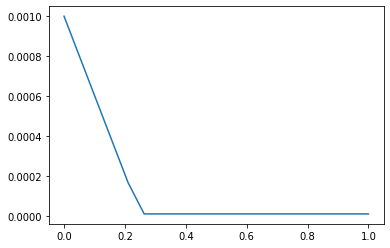

In [125]:
plt.plot(np.linspace(0,1,20), [lr_fun(1-el) for el in np.linspace(0,1,20)])


## Test CustomReward

In [71]:
env_train2 = grid2op.make(ENV_NAME, 
                            reward_class=CustomReward2, 
                            param=p, 
                            backend=LightSimBackend(),
                            chronics_class=MultifolderWithCache)
env_train2.chronics_handler.real_data.set_filter(filter_chronics)
env_train2.chronics_handler.real_data.reset()

array(['/home/boguslawskieva/data_grid2op/l2rpn_wcci_2022_dev/chronics/2050-01-10_0',
       '/home/boguslawskieva/data_grid2op/l2rpn_wcci_2022_dev/chronics/2050-08-01_7'],
      dtype='<U75')

In [5]:
env = grid2op.make(ENV_NAME, reward_class=CustomReward)

In [6]:
def sample_curtailment(env, rnd_update=None):
        unitary_actions = env.action_space.get_all_unitary_curtail(env.action_space)
        rnd_update = env.space_prng.choice(unitary_actions)
        return rnd_update

def sample_storage(env, rnd_update=None):
        unitary_actions = env.action_space.get_all_unitary_storage(env.action_space)
        rnd_update = env.space_prng.choice(unitary_actions)
        return rnd_update


act = env.space_prng.choice([sample_curtailment(env), sample_storage(env)])
act.as_serializable_dict()

{'curtail': [(7, 0.7222222089767456)]}

In [10]:
act = env.space_prng.choice([sample_curtailment(env), sample_storage(env)])
print(act.as_serializable_dict())
obs, reward, done, info = env.step(act)
reward, done

{'set_storage': [(0, -6.0)]}


(0.0, False)

In [13]:
obs.curtailment_mw, obs.curtailment_limit, obs.curtailment_limit_effective#, obs.storage_charge/obs.storage_Emax

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 array([1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
        1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
        1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
        1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
        1.       , 1.       , 1.       , 1.       , 0.6666667, 0.8333333,
        1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
        1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
        1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
        1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
        1.       , 1.       , 1.     

In [45]:
obs.storage_charge, obs.storage_Emin, obs.storage_Emax

(array([24., 12., 24., 12., 24., 24., 12.], dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 array([48., 24., 48., 24., 48., 48., 24.], dtype=float32))

# Test normalization

In [8]:
from grid2op.gym_compat import BoxGymActSpace, BoxGymObsSpace, GymEnv

from l2rpn_baselines.PPO_SB3.utils import (default_obs_attr_to_keep, 
                                           default_act_attr_to_keep,
                                           remove_non_usable_attr,
                                           save_used_attribute)

obs_attr_to_keep = ["month", "day_of_week", "hour_of_day", "minute_of_hour",
                                  "gen_p", "load_p", 
                                  "p_or", "rho", "timestep_overflow", "line_status",
                                  # dispatch part of the observation
                                  "actual_dispatch", "target_dispatch",
                                  # storage part of the observation
                                  "storage_charge", "storage_power",
                                  # curtailment part of the observation
                                  "curtailment", "curtailment_limit",  "gen_p_before_curtail",
                                  ]
act_attr_to_keep = ["curtail", "set_storage"]

act_attr_to_keep = remove_non_usable_attr(env_train, act_attr_to_keep)


# define the gym environment from the grid2op env
gymenv_kwargs = {"safe_max_rho":0.9}
env_gym = gymenv_class(env_train, **gymenv_kwargs)
env_gym.observation_space.close()
env_gym.observation_space = BoxGymObsSpace(env_train.observation_space,
                                        attr_to_keep=obs_attr_to_keep)
env_gym.action_space.close()
env_gym.action_space = BoxGymActSpace(env_train.action_space,
                                    attr_to_keep=act_attr_to_keep)

In [35]:
# {el:env_gym.action_space.dict_properties[el] for el in act_attr_to_keep}
# {el:env_gym.observation_space.dict_properties[el] for el in obs_attr_to_keep}
env_gym.action_space.low, env_gym.action_space.high
env_gym.observation_space.low, env_gym.observation_space.high

(array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([1., 1., 1., ..., 1., 1., 1.], dtype=float32))

In [24]:
# {el:env_gym.action_space.dict_properties[el] for el in act_attr_to_keep}
# {el:env_gym.observation_space.dict_properties[el] for el in obs_attr_to_keep}
{el:np.all(np.isfinite(env_gym.observation_space.dict_properties[el][0])) and np.all(np.isfinite(env_gym.observation_space.dict_properties[el][1])) 
    for el in obs_attr_to_keep}

{'month': True,
 'day_of_week': True,
 'hour_of_day': True,
 'minute_of_hour': True,
 'gen_p': True,
 'load_p': False,
 'p_or': False,
 'rho': False,
 'timestep_overflow': True,
 'line_status': True,
 'actual_dispatch': True,
 'target_dispatch': True,
 'storage_charge': True,
 'storage_power': True,
 'curtailment': True,
 'curtailment_limit': True,
 'gen_p_before_curtail': True}

In [23]:
normalize_act = True
normalize_obs = True
if normalize_act:
    for attr_nm in act_attr_to_keep:
        env_gym.action_space.normalize_attr(attr_nm)

if normalize_obs:
    for attr_nm in obs_attr_to_keep:
        env_gym.observation_space.normalize_attr(attr_nm)